In [4]:
# Imports
#---------
import sys
import pandas as pd
import numpy as np
import feather
import os
import gc
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib as mpl
from datetime import timezone

register_matplotlib_converters()

# File locations
#----------------
the_gases = './oxaria/processed/batch_2_feb21_may21/'
pngs = './oxaria/data/pngs/gap_filling/'

In [5]:
# Load the df 
#-------------
oxaria1_pm = pd.read_feather(the_gases+'oxaria1_pm_q12021_gf.ftr').set_index(['tag','rec'])
oxaria1_pm_lt = oxaria1_pm.iloc[:,[0,1,2,3,28,29,30,31,32,33,34,43]]
del oxaria1_pm

# Checking out the data types 
#-----------------------------
oxaria1_pm_lt.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10228251 entries, ('scs-bgx-536', Timestamp('2021-01-01 00:00:02+0000', tz='UTC')) to ('scs-bgx-543', Timestamp('2021-05-31 23:59:55+0000', tz='UTC'))
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   val.mtf1     float32
 1   val.pm1      float32
 2   val.mtf5     float32
 3   val.pm2p5    float32
 4   val.mtf3     float32
 5   val.pm10     float32
 6   val.mtf7     float32
 7   val.per      float32
 8   val.sfr      float32
 9   val.sht.hmd  float32
 10  val.sht.tmp  float32
 11  name         object 
dtypes: float32(11), object(1)
memory usage: 940.9+ MB


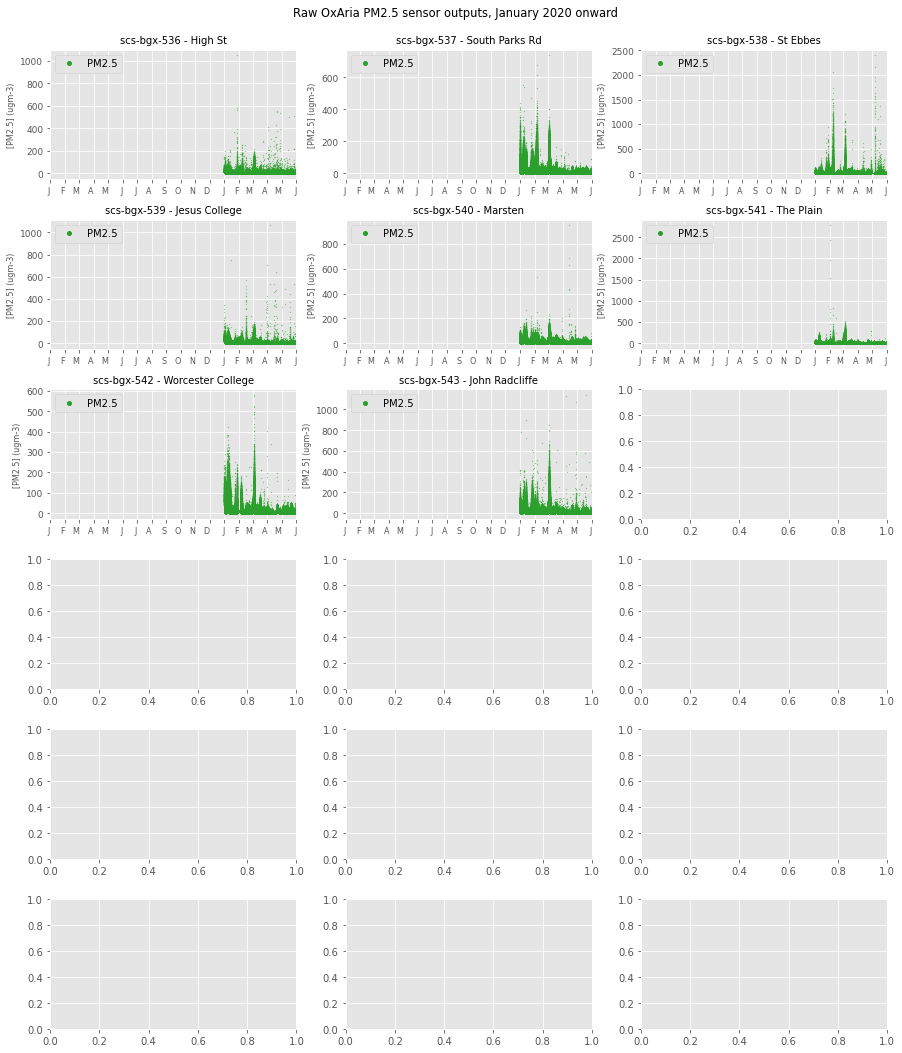

In [7]:
# PM2.5 plots
# -----------
plt.style.use('ggplot')
x_ticks = pd.date_range('2020-01-01', periods=18, freq='MS')
x_labels = [
    'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M',
    'A', 'M', 'J'
]

myFmt = mdates.DateFormatter('%b')
start_date=dt.datetime(2020,1,1)
end_date=dt.datetime(2021,6,1)

fig, axes = plt.subplots(nrows=6, ncols=3, sharex=False,
                         sharey=False, figsize=(15, 20))
axes_list = [item for sublist in axes for item in sublist]

fig.suptitle('Raw OxAria PM2.5 sensor outputs, January 2020 onward',
             fontsize=11.5, y=0.91)

for tag, dat in oxaria1_pm_lt.groupby('tag'):
    ax = axes_list.pop(0)
    dat.reset_index(level=0, inplace=True)
    t_name = dat['name'].unique()
    dat.plot(y='val.pm2p5', c='tab:green', linewidth=0.5, marker='o', ms=0.2, ls='',
             label='PM2.5', ax=ax, legend=True, zorder=1)
    ax.set_title(''.join(tag+' - '+t_name), fontsize=10)
    ax.tick_params(
        axis='x',
        which='major',
        labelrotation=0,
        labelsize=8
    )
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', which='minor', length=0.2)
    ax.set_xlim(start_date, end_date)
    ax.set_ylabel('[PM2.5] (ugm-3)', fontsize=8)
    ax.set_xlabel('')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    plt.subplots_adjust(wspace=0.2, hspace=0.31)
    ax.legend(markerscale=20, frameon=True, framealpha=0.99, loc='upper left')

#plt.savefig(pngs+'oxaria0_pm25_15m_raw_sensor_ts_536_q12021.png')
plt.show()

for ax in axes_list:
    ax.remove()

In [9]:
# Some cleaning incase have missed anything
#-------------------------------------------
oxaria1_pm_lt = oxaria1_pm_lt[~oxaria1_pm_lt.index.duplicated(keep='last')].reset_index()
oxaria1_pm_lt = oxaria1_pm_lt.dropna(axis=0,subset=['tag','rec']).set_index(['tag','rec']).sort_index()

In [ ]:
# There don't seem to be any outages that need removing so just saving

In [10]:
# Apply empirical filters
#-------------------------
cols = ['val.pm10','val.pm2p5','val.pm1']

condition =  ((oxaria1_pm_lt['val.sfr'] < 2.0) | \
             (oxaria1_pm_lt['val.sht.tmp'] < -10.0) | \
             (oxaria1_pm_lt['val.sht.tmp'] > 35.0) | \
             (oxaria1_pm_lt['val.sht.hmd'] < 35.0))

for col in cols:
    oxaria1_pm_lt[col+'_1'] = np.where(condition, np.nan, oxaria1_pm_lt[col])

# Save to feather
#-----------------
oxaria1_pm_lt.reset_index().to_feather(the_gases+'oxaria1_pm_stable_536_q12021.ftr')

In [15]:
oxaria1_pm_lt.info(null_counts=True) #.set_index(['tag','rec']).info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10228251 entries, ('scs-bgx-536', Timestamp('2021-01-01 00:00:02+0000', tz='UTC')) to ('scs-bgx-543', Timestamp('2021-05-31 23:59:55+0000', tz='UTC'))
Data columns (total 15 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   val.mtf1     10228251 non-null  float32
 1   val.pm1      10228251 non-null  float32
 2   val.mtf5     10228251 non-null  float32
 3   val.pm2p5    10228251 non-null  float32
 4   val.mtf3     10228251 non-null  float32
 5   val.pm10     10228251 non-null  float32
 6   val.mtf7     10228251 non-null  float32
 7   val.per      10228251 non-null  float32
 8   val.sfr      10228251 non-null  float32
 9   val.sht.hmd  10228251 non-null  float32
 10  val.sht.tmp  10228251 non-null  float32
 11  name         10228251 non-null  object 
 12  val.pm10_1   7247052 non-null   float32
 13  val.pm2p5_1  7247052 non-null   float32
 14  val.pm1_1    7247052 non-null   float32
d